In [20]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [21]:
import string
import math
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import lightgbm as lgbm
import xgboost as xgb
import catboost as cb

In [23]:
train_df= pd.read_csv('/kaggle/input/musicdataset/train.csv')
members_df = pd.read_csv('/kaggle/input/musicdataset/members.csv')
songs_df = pd.read_csv('/kaggle/input/musicdataset/songs.csv')
song_extra_df = pd.read_csv('/kaggle/input/musicdataset/song_extra_info.csv')

In [24]:
train_df.head(5)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [25]:
song_extra_df.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [26]:
songs_df.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [27]:
members_df.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [28]:
merge_1 = pd.merge(train_df, songs_df, on = 'song_id', how = 'left')
merge_2 = pd.merge(merge_1, song_extra_df, on = 'song_id', how = 'left')
songs = pd.merge(merge_2, members_df, on = 'msno', how = 'left')
del train_df, songs_df, song_extra_df, members_df, merge_1, merge_2
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,Good Grief,GBUM71602854,1,0,NaN,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0,Lords of Cardboard,US3C69910183,13,24,female,9,20110525,20170911
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,20110525,20170911
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,Disco Africa,GBUQH1000063,13,24,female,9,20110525,20170911
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,Sleep Without You,QM3E21606003,1,0,NaN,7,20120102,20171005


In [29]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 20 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   msno                    object 
 1   song_id                 object 
 2   source_system_tab       object 
 3   source_screen_name      object 
 4   source_type             object 
 5   target                  int64  
 6   song_length             float64
 7   genre_ids               object 
 8   artist_name             object 
 9   composer                object 
 10  lyricist                object 
 11  language                float64
 12  name                    object 
 13  isrc                    object 
 14  city                    int64  
 15  bd                      int64  
 16  gender                  object 
 17  registered_via          int64  
 18  registration_init_time  int64  
 19  expiration_date         int64  
dtypes: float64(2), int64(6), object(12)
memory usage: 1.2+ GB


In [30]:
songs.shape

(7377418, 20)

In [31]:
songs.isnull().sum()

msno                            0
song_id                         0
source_system_tab           24849
source_screen_name         414804
source_type                 21539
target                          0
song_length                   114
genre_ids                  118455
artist_name                   114
composer                  1675706
lyricist                  3178798
language                      150
name                         1457
isrc                       577858
city                            0
bd                              0
gender                    2961479
registered_via                  0
registration_init_time          0
expiration_date                 0
dtype: int64

<Axes: >

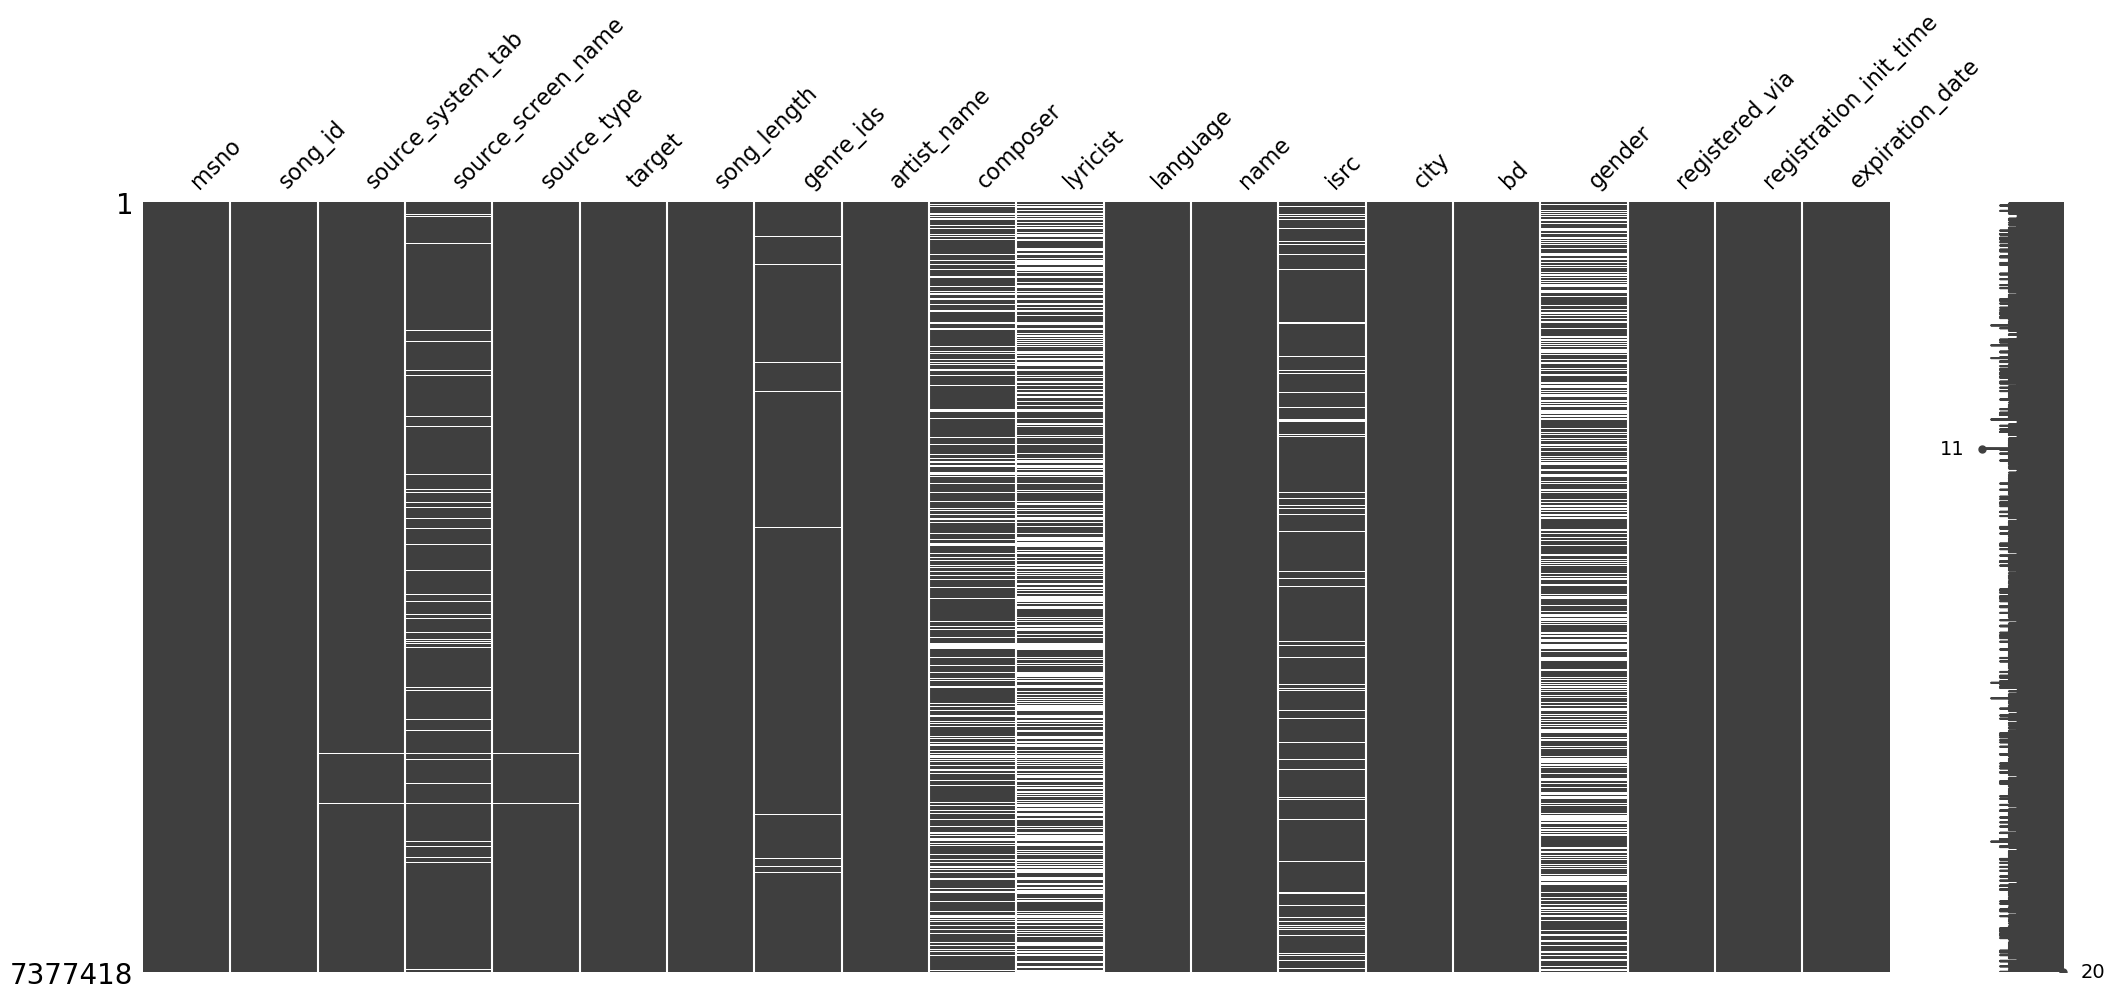

In [32]:
msno.matrix(songs)

In [33]:
for i in songs.select_dtypes(include=['object']).columns:
    songs[i][songs[i].isnull()] = 'unknown'
songs.fillna(value = 0).tail()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
7377413,6xdFzPlrasIDD95mQWXVC3Bg4ptnGYtBl4ztVEZMddU=,VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=,my library,Local playlist more,local-playlist,1,267958.0,1259,Dr. Dre,Andre R. Young| Melvin Charles Bradford| Shawn...,unknown,52.0,Still D.R.E.,USIR19905031,4,26,female,9,20041218,20170930
7377414,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,z1mqaU9YOX7T/PFDvUoWozdFq7rC3KwaQP7nFVprjMI=,search,Search,song,0,227404.0,465,R. City feat. Adam Levine,Theron Thomas| Timothy Thomas| Lukasz Gottwald...,Theron Thomas| Timothy Thomas| Lukasz Gottwald...,52.0,Locked Away,USRC11501369,1,0,unknown,7,20130627,20171006
7377415,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,search,Search,song,1,258298.0,465,兄弟本色G.U.T.S. (姚中仁、張震嶽、頑童MJ116),姚中仁 MC HotDog 陳昱榕 Ｅ-SO 周文傑 KENZY 林睦淵,姚中仁 MC HotDog 陳昱榕 Ｅ-SO 周文傑 KENZY 林睦淵,3.0,FLY OUT,TWA451512031,1,0,unknown,7,20130627,20171006
7377416,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=,discover,Discover Genre,online-playlist,1,524146.0,2122,Brad Mehldau Trio,unknown,unknown,52.0,Wonderwall,USNO10750721,5,0,unknown,9,20150213,20170918
7377417,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,Ju0VGkjWeBUZCd7r5Az2hUImhMoWxWLUicOedsmvG0g=,discover,Discover Genre,online-playlist,1,254026.0,212,Biréli Lagrène| Sylvain Luc,Robert Andrew Hyman| Cyndy Lauper,Robert Andrew Hyman| Cyndy Lauper,52.0,Time after time,FR14F9900090,5,0,unknown,9,20150213,20170918


<Axes: >

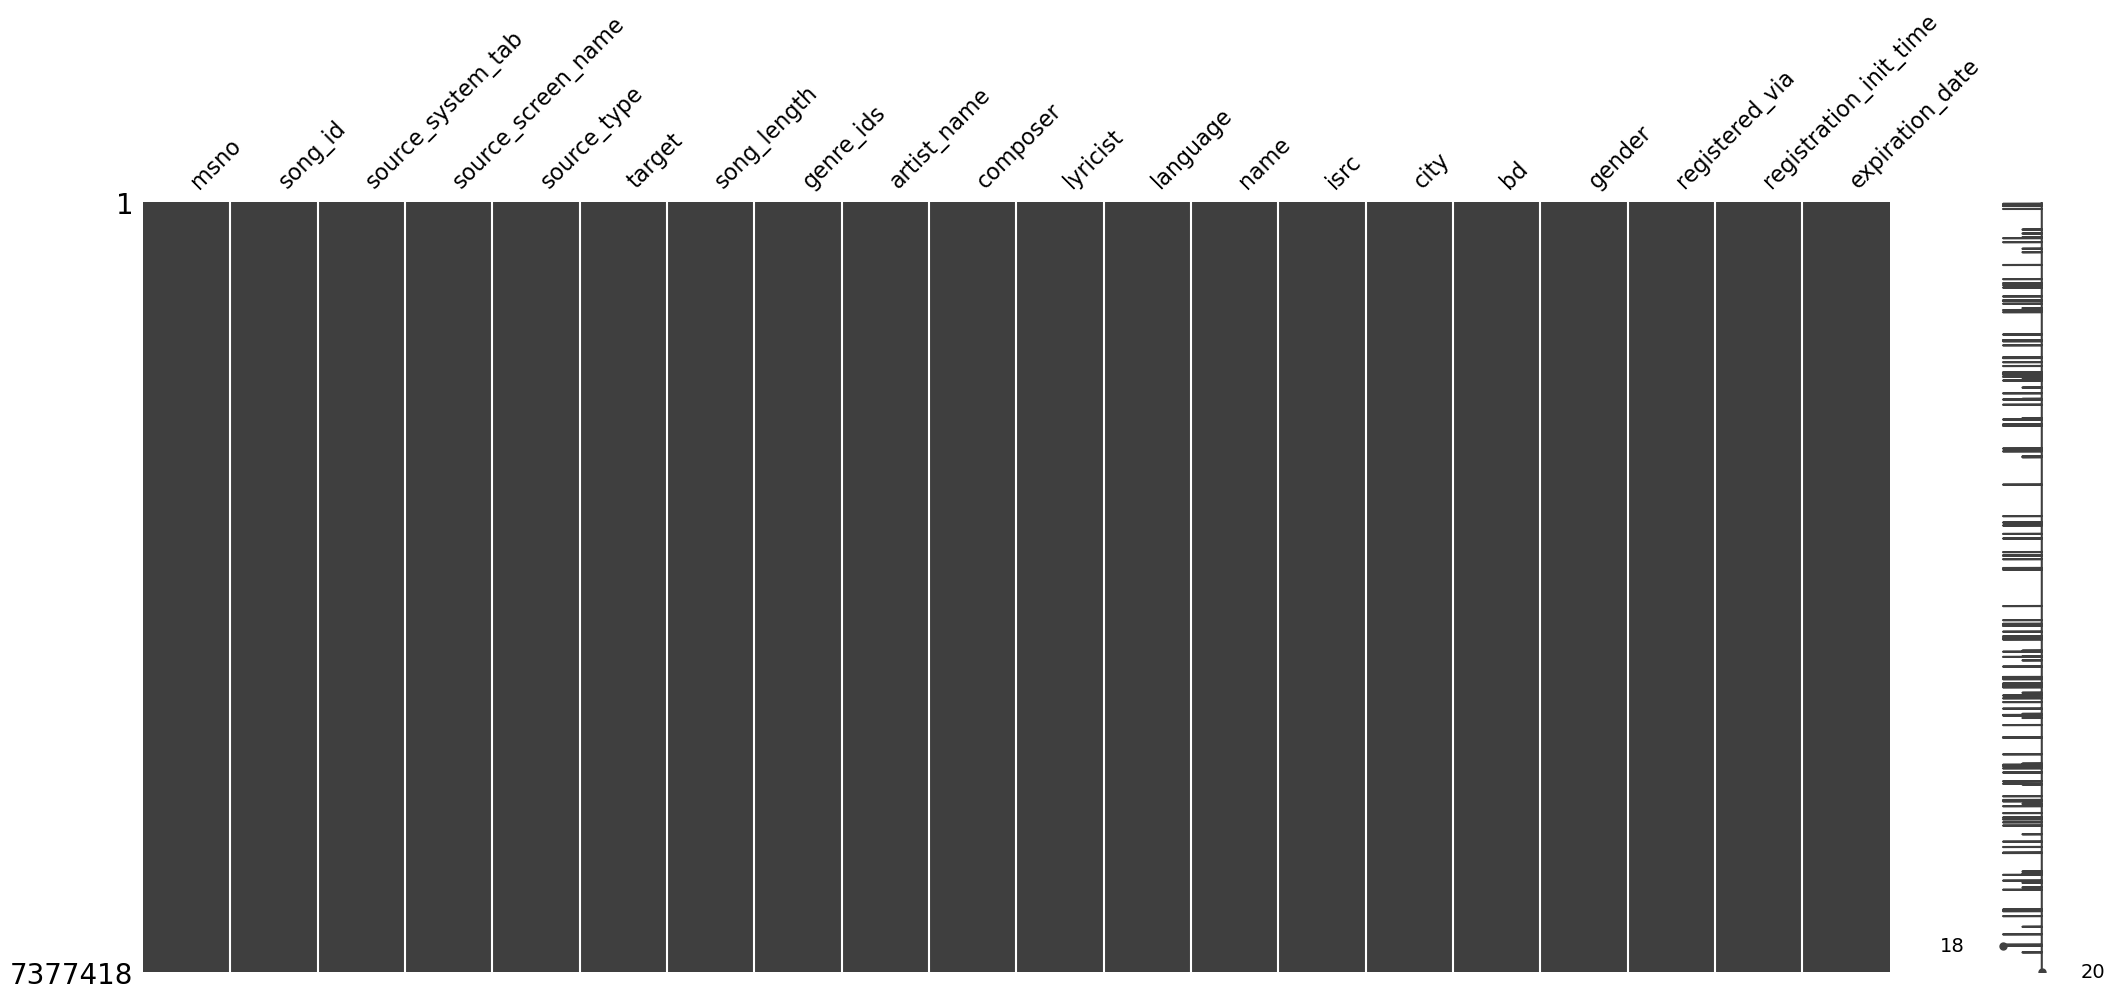

In [34]:
msno.matrix(songs)

In [35]:
songs.registration_init_time = pd.to_datetime(songs.registration_init_time, format='%Y%m%d', errors='ignore')
songs['registration_init_time_year'] = songs['registration_init_time'].dt.year
songs['registration_init_time_month'] = songs['registration_init_time'].dt.month
songs['registration_init_time_day'] = songs['registration_init_time'].dt.day

# expiration_date
songs.expiration_date = pd.to_datetime(songs.expiration_date,  format='%Y%m%d', errors='ignore')
songs['expiration_date_year'] = songs['expiration_date'].dt.year
songs['expiration_date_month'] = songs['expiration_date'].dt.month
songs['expiration_date_day'] = songs['expiration_date'].dt.day

In [36]:
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,unknown,52.0,Good Grief,GBUM71602854,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,unknown,unknown,52.0,Lords of Cardboard,US3C69910183,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,unknown,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,unknown,-1.0,Disco Africa,GBUQH1000063,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,unknown,52.0,Sleep Without You,QM3E21606003,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5


In [37]:
label_encoder = LabelEncoder()
one_hot = OneHotEncoder()

for i in songs.columns :
    songs[i] = label_encoder.fit_transform(songs[i])

In [38]:
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,8158,74679,1,7,6,1,19020,285,3277,14581,22976,8,51445,65244,0,2,2,2,2131,989,8,0,1,14,9,4
1,17259,223479,3,8,4,1,36984,90,31960,64996,22976,8,81301,195670,11,21,0,3,1909,965,7,4,24,14,8,10
2,17259,120758,3,8,4,1,23675,90,21372,45057,22976,8,57307,253629,11,21,0,3,1909,965,7,4,24,14,8,10
3,17259,23707,3,8,4,1,30969,6,27439,36700,22976,0,34728,65572,11,21,0,3,1909,965,7,4,24,14,8,10
4,8158,33308,1,7,6,1,14877,2,4472,8485,22976,8,121801,131942,0,2,2,2,2131,989,8,0,1,14,9,4


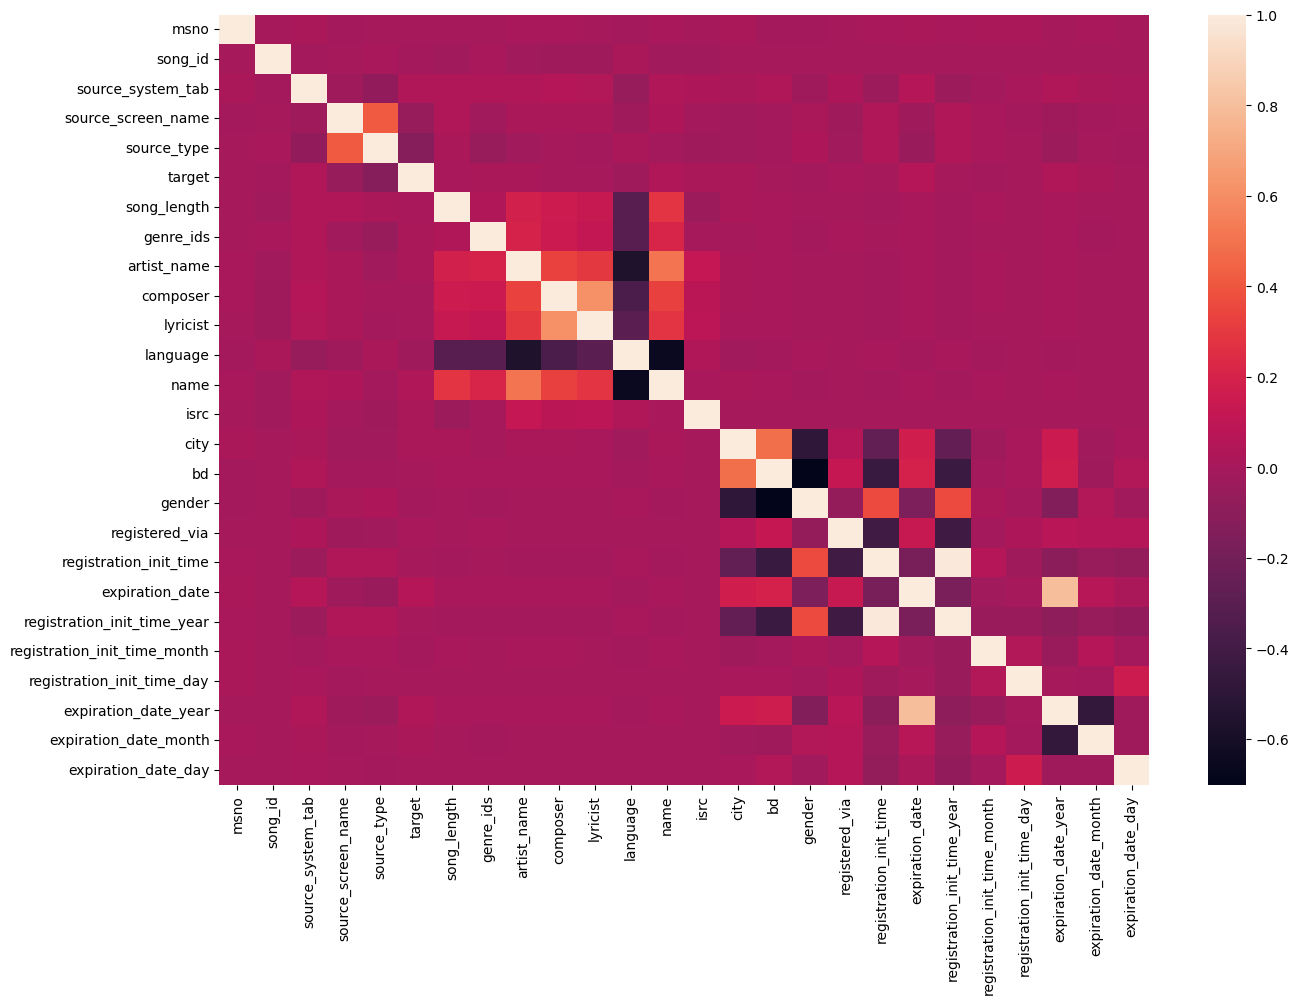

In [39]:
plt.figure(figsize=[15,10])
sns.heatmap(songs.corr()) #annot = True
plt.show()

In [40]:
songs.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_length', 'genre_ids', 'artist_name',
       'composer', 'lyricist', 'language', 'name', 'isrc', 'city', 'bd',
       'gender', 'registered_via', 'registration_init_time', 'expiration_date',
       'registration_init_time_year', 'registration_init_time_month',
       'registration_init_time_day', 'expiration_date_year',
       'expiration_date_month', 'expiration_date_day'],
      dtype='object')

In [41]:
X = songs.drop('target', axis = 1)
y = songs['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 0)


In [42]:
def model_with(model_name, X_train, X_val, y_train, y_val) :
    print("==================================================")
    print("Modeling with :", model_name)
    print()
        
    if model_name == "Random Forest Classifier" :
        model = RandomForestClassifier(
            n_estimators=1000, 
        )
    elif model_name == "Extra Trees Classifier" :
        model = ExtraTreesClassifier(
            n_estimators=1000, 
        )
    elif model_name == "LightGBM Classifier" :
        model = lgbm.LGBMClassifier(
            n_estimators=1000, 
        )
    elif model_name == "XGBoost Classifier" :
        model = xgb.XGBClassifier(
            n_estimators=1000, 
        )
    elif model_name == "CatBoost Classifier" :
        model = cb.CatBoostClassifier(
            n_estimators=1000, 
            verbose=0
        )
    else :
        print("Model not found in function.")
        
    model.fit(X_train, y_train)
    
    val_pred = model.predict(X_val)
    print(classification_report(y_val, val_pred))
    print()
    print("Accuracy :", accuracy_score(y_val, val_pred))
    print("ROC :", roc_auc_score(y_val, val_pred))
    
    print("==================================================")
    print()

In [ ]:
models = ["Random Forest Classifier", "Extra Trees Classifier", "LightGBM Classifier", "XGBoost Classifier", "CatBoost Classifier"]
for i in models :
    model_with(i, X_train, X_val, y_train, y_val)

Modeling with : Random Forest Classifier

